In [1]:
from PIL import ImageFont, ImageDraw, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Callable
from collections import namedtuple

# делаем датасет

In [2]:
font = ImageFont.truetype("font.ttf", size=8)

In [3]:
def gen_data(char):
    img = Image.new("1", (8, 8), "white")
    draw = ImageDraw.Draw(img)
    draw.text((0, 0), char, font=font)
    bit = np.asarray(img)
    bit = np.matrix.flatten(bit)
    bit = bit - bit.mean()
    return char, img,  bit

In [4]:
symbols = [chr(i) for i in range(ord('a'), ord('z'))] + \
    [chr(i) for i in range(ord('а'), ord('я'))] + \
    [chr(i) for i in range(ord('0'), ord('9')+1)]

# symbols = [chr(i) for i in range(ord('0'), ord('9')+1)]

In [5]:
ds = pd.DataFrame(columns=['char', 'img', 'bit'])

for char in symbols:
    ds.loc[len(ds)] = gen_data(char)

ds = ds.set_index(ds['char'])
ds.iloc[5].img

In [6]:
# ds = pd.DataFrame(columns=['char', 'bit'])
# ds.loc[len(ds)] = ['0', [-1]*32 + [1]*32]
# ds.loc[len(ds)] = ['1', [1]*32 + [-1]*32]
# ds = ds.set_index(ds['char'])
# ds

# гиперпараметры

In [7]:
def sigmoid(x): return 1/(1+np.exp(-x))
def sigmoid_der(x): return sigmoid(x)*(1-sigmoid(x))


def linear(x): return x
def linear_der(x): return 1


def relu(x): return x if x > 0 else 0
def relu_der(x): return 1 if x > 0 else 0


def tanh(x): return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)


def tanh_der(x): return 1 - tanh(x)**2

In [8]:
LR = 0.05
Activations = namedtuple('Activations', ['func', 'dfunc', 'f', 't'])

# перцептрон

In [9]:
class Perceptron:
    weights: np.array
    f: Callable[[float], float]
    der_f: Callable[[float], float]

    def __init__(self, f, der_f, input_len):
        self.weights = np.random.rand(input_len+1)-0.5
        self.f = f
        self.der_f = der_f

    def predict(self, inputs):
        return self.f(self.weights @ np.append([1], inputs))

    def fit(self, inputs: np.array, target):
        inputs = np.append(np.array([1]), inputs)
        s = self.weights @ inputs
        y = self.f(s)
        err = (target - y)**2/2

        dw = -1 * (target - y) * self.der_f(s) * inputs
        if np.linalg.norm(dw) > 0.001:
            dw = dw/np.linalg.norm(dw)
        # print(f'shift = {abs(dw).mean()}')
        # print(f'target is {target}, y is {y}')
        self.weights -= LR * dw

        # print(f'target is {target}: {y} -> {self.f(self.weights @ inputs)}')
        return y

    def update_weights(self, predicted, target):
        err = (predicted - target)**2
        dw = err * self.activation(y_predict, True)

In [10]:
class Ansambler:
    ds: pd.DataFrame
    neurons: dict[str, Perceptron]
    activations: Activations

    def __init__(self, ds: pd.DataFrame, act):
        self.ds = ds
        self.neurons = dict()
        self.activations = act
        for _, row in self.ds.iterrows():
            self.neurons[row.char] = Perceptron(
                self.activations.func, self.activations.dfunc, 64)

    def fit(self, matrix, char):
        res = dict()

        for nch, neuron in self.neurons.items():
            res[nch] = neuron.fit(
                matrix, self.activations.t if nch == char else self.activations.f)
            # print(f'neuron {nch} fittend with {char} and calculated {res[nch]}')

        pred = max(res.keys(), key=lambda x: res[x])
        return int(pred == char)

    def fit_positive(self):
        res = dict()

        for nch, neuron in self.neurons.items():
            res[nch] = neuron.fit(self.ds.loc[nch].bit, self.activations.t)

    def train_epoch(self):
        results = []
        for _, row in self.ds.sample(frac=1).iterrows():
            res = self.fit(row.bit, row.char)
            # print(f'ansamble guessed {row.char}: {bool(res)}')
            self.fit_positive()
            results.append(res)
        return sum(results)/len(self.ds)

    def train(self, num_epoch=20):
        results = []
        for i in tqdm(range(num_epoch)):
            res = self.train_epoch()
            results.append(res)
            # print(f'epoch {i}: {res}')
        plt.plot(np.arange(1, num_epoch+1), results)
        plt.grid()
        plt.show()

In [11]:
LR = 0.04
Ansambler(ds, Activations(sigmoid, sigmoid_der, 0, 1)).train(30)

  0%|          | 0/30 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [00:11<00:03,  2.05it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:15<00:00,  1.99it/s]


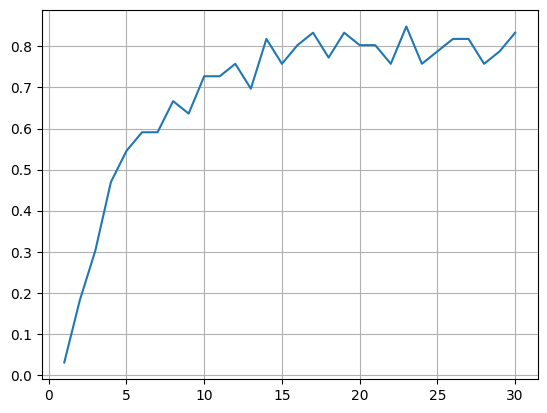

In [ ]:
LR = 0.04
Ansambler(ds, Activations(linear, linear_der, 0, 1)).train(30)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:15<00:00,  2.00it/s]


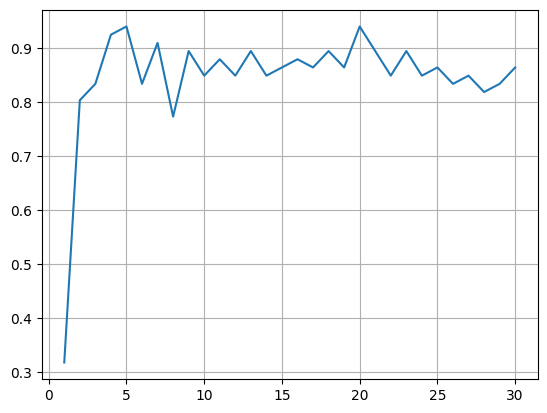

In [ ]:
LR = 0.035
Ansambler(ds, Activations(tanh, tanh_der, -1, 1)).train(30)

100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


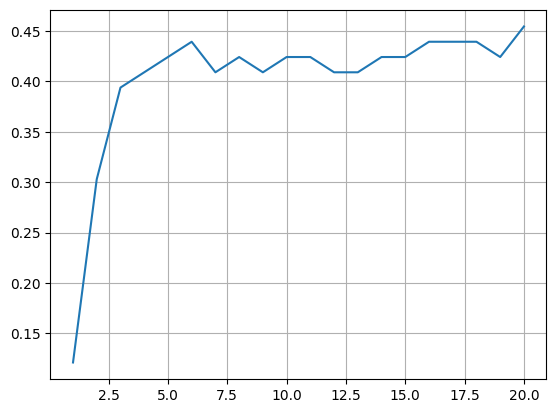

In [ ]:
LR = 0.04
Ansambler(ds, Activations(relu, relu_der, -1, 1)).train(30)